# Importing libs

In [ ]:
import os
import librosa
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fftpack import dct
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers;

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis


2025-04-06 14:07:15.037633: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 14:07:15.127332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 14:07:15.155605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743959235.201950  233308 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743959235.210329  233308 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743959235.288044  233308 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Creating dataframe

In [40]:
base_path = "TinySOL/"
instruments_type = ["Brass", "Keyboards", "Strings", "Winds"]
instruments = [
    ["Trombone", "Bass_Tuba", "Horn", "Trumpet_C"],
    ["Accordion"],
    ["Violin", "Contrabass", "Viola", "Violoncello"],
    ["Flute", "Bassoon", "Clarinet_Bb", "Flute", "Oboe", "Sax_Alto"]
]

instruments_df = []

i = 0
for instrument_type, s_instrument in zip(instruments_type, instruments):
    for instrument in s_instrument:
        full_path = os.path.join(base_path, instrument_type, instrument, "ordinario/")
        note_value = []
        qct_frequencies_per_note = []
        mfc_per_note = []

        df_instrument = {
            'instrument_name': instrument
        }
        print(full_path)
        
        for file in os.listdir(full_path):
            if file.endswith(".wav"):
                note = file.split('-')[2]
                wav_path = os.path.join(full_path, file)
                y, sr = librosa.load(wav_path, sr=None)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 coeficientes
    
            
                note_value.append(note)
                mfc_per_note.append(mfcc)
                i += 1

        df_instrument['note'] = note_value
        df_instrument['mfcc'] = mfc_per_note
        df_instrument = pd.DataFrame(df_instrument)
        instruments_df.append(df_instrument)

instruments_df = pd.concat(instruments_df, ignore_index=True)


TinySOL/Brass/Trombone/ordinario/
TinySOL/Brass/Bass_Tuba/ordinario/
TinySOL/Brass/Horn/ordinario/
TinySOL/Brass/Trumpet_C/ordinario/
TinySOL/Keyboards/Accordion/ordinario/
TinySOL/Strings/Violin/ordinario/
TinySOL/Strings/Contrabass/ordinario/
TinySOL/Strings/Viola/ordinario/
TinySOL/Strings/Violoncello/ordinario/
TinySOL/Winds/Flute/ordinario/
TinySOL/Winds/Bassoon/ordinario/
TinySOL/Winds/Clarinet_Bb/ordinario/
TinySOL/Winds/Flute/ordinario/
TinySOL/Winds/Oboe/ordinario/
TinySOL/Winds/Sax_Alto/ordinario/


# Saving dataframe as jsonl

In [28]:
instruments_df.to_json('dataset/dataset.jsonl', orient='records', lines=True)

# Load dataset

In [29]:
instruments_df = pd.read_json('dataset/dataset.jsonl', lines=True)

instruments_df.head()

,instrument_name,note,mfcc
0,Trombone,A#1,"[[-599.45703125, -597.9332885742, -517.8503417..."
1,Trombone,A#1,"[[-631.5947875977, -650.9674682617, -664.12689..."
2,Trombone,A#1,"[[-650.5833740234, -668.1877441406, -710.47003..."
3,Trombone,A#2,"[[-524.6920166016, -471.476776123, -381.313201..."
4,Trombone,A#2,"[[-663.5693969727, -619.8080444336, -551.34252..."


# Processing dataset
1. Processing missing datas
2. Data Augmentation
3. Balance in terms of instruments 

In [369]:
print(instruments_df["instrument_name"].value_counts())


instrument_name
Accordion      689
Contrabass     309
Viola          309
Violoncello    291
Violin         284
Flute          236
Horn           134
Bassoon        126
Clarinet_Bb    126
Trombone       117
Bass_Tuba      108
Oboe           107
Sax_Alto        99
Trumpet_C       96
Name: count, dtype: int64


In [30]:
p_instruments_df = instruments_df[
    instruments_df['instrument_name'].notna() & (instruments_df['instrument_name'].str.strip() != "")
].reset_index(drop=True)

print("Linhas removidas:", len(instruments_df) - len(p_instruments_df))

Linhas removidas: 0


## Aux Functions

In [31]:
def get_enhanced_mfcc_features(mfcc):
    """
    Função ampliada para extração de features de MFCC
    mfcc_mean: Média dos coeficientes MFCC
    mfcc_std: Desvio padrão dos coeficientes
    mfcc_skew: Assimetria da distribuição
    mfcc_kurt: Curtose da distribuição
    delta_mean: Média das primeiras derivadas
    delta_std: Desvio padrão das derivadas
    mfcc_0 a mfcc_12: Valores médios de cada coeficiente
    """
    
    # Garantir que o MFCC seja um array numpy
    mfcc = np.array(mfcc)

    stats = {}
    
    # Features básicas para cada coeficiente
    for i in range(mfcc.shape[0]):
        coeff = mfcc[i]
        stats.update({
            f'mfcc_{i}_mean': np.mean(coeff),
            f'mfcc_{i}_std': np.std(coeff),
            f'mfcc_{i}_skew': skew(coeff) if len(coeff) > 2 else 0,
            f'mfcc_{i}_kurt': kurtosis(coeff) if len(coeff) > 3 else 0
        })
    
    # Features temporais (derivadas)
    if mfcc.shape[1] > 1:
        deltas = np.diff(mfcc, axis=1)
        stats.update({
            'delta_mean': np.mean(deltas),
            'delta_std': np.std(deltas)
        })
    else:
        stats.update({'delta_mean': 0, 'delta_std': 0})
    
    # Features de energia espectral
    stats['mfcc_energy'] = np.sum(np.square(mfcc))
    
    # Valores médios de cada coeficiente
    for i in range(mfcc.shape[0]):
        stats[f'mfcc_{i}'] = np.mean(mfcc[i])
        
    return stats


def create_features_instruments(df):
    """
    Processa um DataFrame com colunas: instrument_name, note, frequencies
    Retorna features estatísticas e o target codificado
    
    Parâmetros:
    df : DataFrame com colunas ['instrument_name', 'note', 'frequencies']
    
    Retorna:
    X : DataFrame com features
    y : Série com target codificado
    le : LabelEncoder ajustado
    """

    # Extração de features
    df_stats = df["mfcc"].apply(get_enhanced_mfcc_features).apply(pd.Series)
    
    # Junção com os dados originais
    df = pd.concat([df, df_stats], axis=1).dropna()
    
    # Codificação do target
    le = LabelEncoder()
    df["instrument_encoded"] = le.fit_transform(df["instrument_name"])
    
    # Seleção automática de features numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [col for col in numeric_cols if col not in ['instrument_encoded']]
    
    return df[features], df["instrument_encoded"], le

## Training the models 

In [32]:

X, y, le = create_features_instruments(instruments_df)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


# Divisão inicial com stratify (60% treino, 40% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y,
    test_size=0.4,
    stratify=y, 
    random_state=42
)

# Divisão do temp em val/teste (50/50) com stratify
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.5,
    stratify=y_temp, 
    random_state=42
)

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Lista de modelos
modelos = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
}

# Rodar todos
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Modelo: {nome}")
    print(f"Acurácia validaçao: {acc:.4f}")
    print("-" * 30)


X shape: (3031, 68)
y shape: (3031,)
Modelo: Random Forest
Acurácia validaçao: 0.9703
------------------------------
Modelo: Decision Tree
Acurácia validaçao: 0.8663
------------------------------
Modelo: Logistic Regression
Acurácia validaçao: 0.9785
------------------------------
Modelo: SVM
Acurácia validaçao: 0.9785
------------------------------


In [33]:
print("Distribuição original:", np.bincount(y))
print("Treino:", np.bincount(y_train))
print("Validação:", np.bincount(y_val))
print("Teste:", np.bincount(y_test))

Distribuição original: [689 108 126 126 309 236 134 107  99 117  96 309 284 291]
Treino: [413  65  76  76 185 142  80  64  59  70  58 185 170 175]
Validação: [138  21  25  25  62  47  27  22  20  23  19  62  57  58]
Teste: [138  22  25  25  62  47  27  21  20  24  19  62  57  58]


# Choose Random Forest, and gets the best params

In [34]:

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)
print("Melhores hiperparâmetros:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 173}


In [35]:
# Para validação
y_val_pred = random_search.predict(X_val)
print("Validação:\n", classification_report(y_val, y_val_pred))

# Para teste
y_test_pred = random_search.predict(X_test)
print("Teste:\n", classification_report(y_test, y_test_pred))


Validação:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       138
           1       0.95      1.00      0.98        21
           2       0.92      0.96      0.94        25
           3       0.96      0.88      0.92        25
           4       0.98      1.00      0.99        62
           5       0.96      1.00      0.98        47
           6       0.93      0.93      0.93        27
           7       0.91      0.91      0.91        22
           8       1.00      0.95      0.97        20
           9       0.95      0.87      0.91        23
          10       0.95      1.00      0.97        19
          11       1.00      0.98      0.99        62
          12       0.98      0.98      0.98        57
          13       1.00      0.98      0.99        58

    accuracy                           0.98       606
   macro avg       0.96      0.96      0.96       606
weighted avg       0.98      0.98      0.98       606

Teste:
      

In [36]:
# Número de classes (instrumentos)
num_classes = len(np.unique(y))
print(f"num_classes: {num_classes}")
print(y_train)

# Codificar o target para one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Definir modelo
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # saída com softmax para classificação multiclasse
])

opt = optimizers.Adam(learning_rate = 0.001)
# Compilar
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Treinar
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    verbose=1
)


num_classes: 14
2038    11
419     10
1707     4
251      6
917      0
        ..
2436     5
1792    11
1466     4
1081     0
988      0
Name: instrument_encoded, Length: 1818, dtype: int64


/home/leandrobandeira/Documentos/UFPB/IdentificadorAcorde/.venv/lib64/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1743960085.197977  233308 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743960085.202801  233308 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2054 - loss: 2.4499 - val_accuracy: 0.5248 - val_loss: 1.4629
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5299 - loss: 1.3922 - val_accuracy: 0.7591 - val_loss: 0.8056
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 0.9176 - val_accuracy: 0.8267 - val_loss: 0.5145
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7524 - loss: 0.7247 - val_accuracy: 0.8861 - val_loss: 0.3798
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8244 - loss: 0.5196 - val_accuracy: 0.9043 - val_loss: 0.3050
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8420 - loss: 0.4650 - val_accuracy: 0.9059 - val_loss: 0.2561
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8631 - loss: 0.3749 - val_accuracy: 0.9356 - val_loss: 0.2116
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8995 - loss: 0.3096 - val_accuracy: 0.9472 - v


 Acurácia final no conjunto de teste: 0.9884678721427917
Classification Report:
              precision    recall  f1-score   support

   Accordion       1.00      1.00      1.00       138
   Bass_Tuba       1.00      0.95      0.98        22
     Bassoon       0.96      1.00      0.98        25
 Clarinet_Bb       0.92      0.92      0.92        25
  Contrabass       1.00      1.00      1.00        62
       Flute       1.00      1.00      1.00        47
        Horn       0.96      0.96      0.96        27
        Oboe       0.91      1.00      0.95        21
    Sax_Alto       1.00      0.90      0.95        20
    Trombone       0.96      0.96      0.96        24
   Trumpet_C       1.00      1.00      1.00        19
       Viola       1.00      1.00      1.00        62
      Violin       1.00      1.00      1.00        57
 Violoncello       1.00      1.00      1.00        58

    accuracy                           0.99       607
   macro avg       0.98      0.98      0.98       607

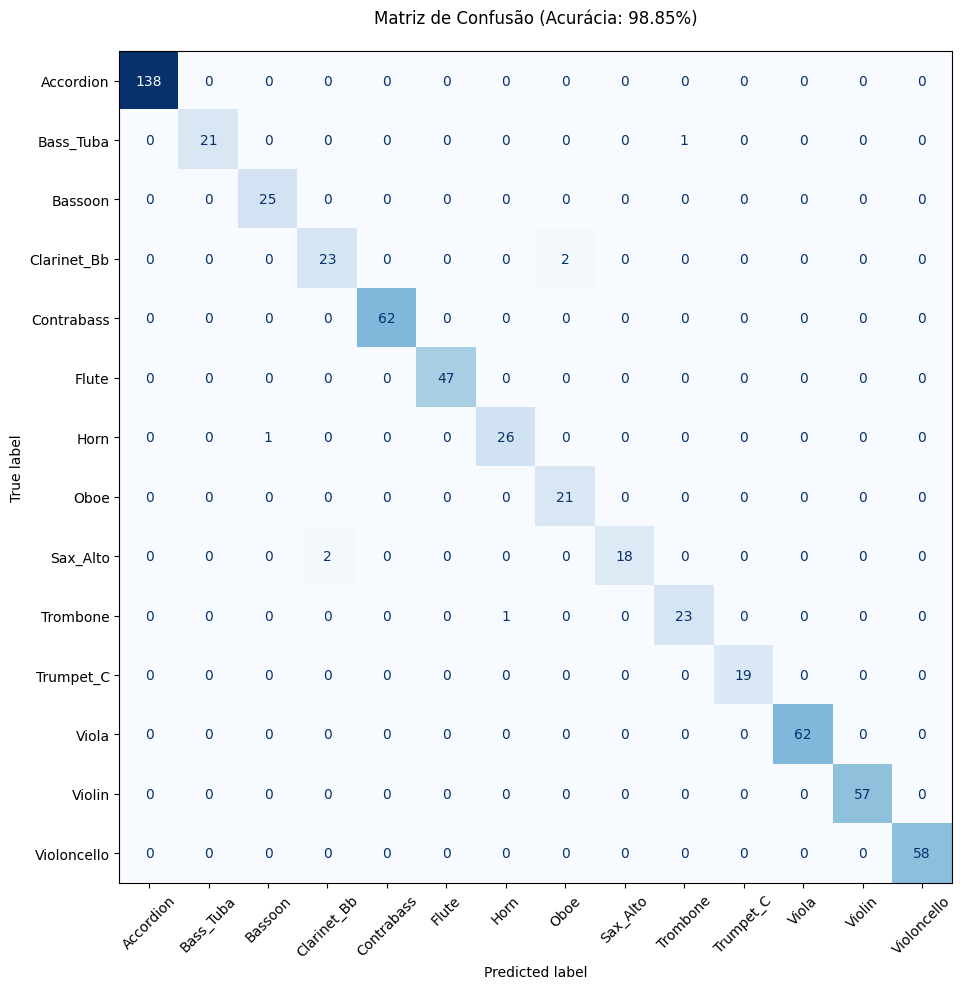

In [37]:
# Avaliar no conjunto de teste
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n Acurácia final no conjunto de teste: {acc}")
# 2. Previsões para a matriz de confusão
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converte de one-hot para classes
y_true_classes = np.argmax(y_test_cat, axis=1)

# Exibir o classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
print("Classification Report:")
print(report)

# 3. Matriz de confusão
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Plot personalizado
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_  
)
disp.plot(
    cmap='Blues',
    xticks_rotation=45,
    ax=ax,
    values_format='d',
    colorbar=False
)
plt.title(f"Matriz de Confusão (Acurácia: {acc:.2%})", pad=20)
plt.tight_layout()
plt.show()

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,892 (230.05 KB)

 Trainable params: 19,630 (76.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,262 (153.37 KB)

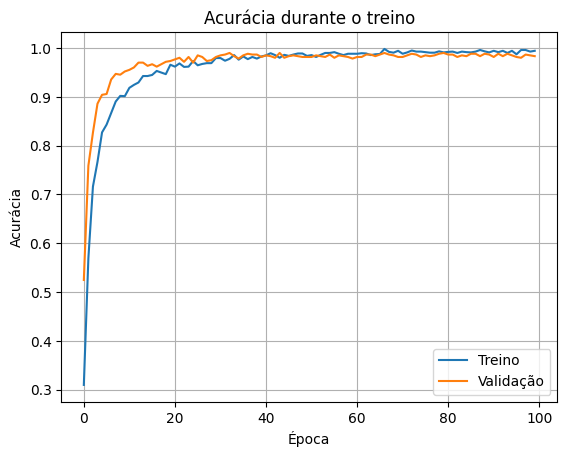

In [39]:


plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treino')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()